In [1]:
import numpy as np
import soundfile as sf
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

from soundbay.utils.metadata_processing import create_wav_info_df

In [2]:
# get all files in fannie dataset
data_dir = Path('./datasets/fannie_project/')
wav_df = create_wav_info_df(list(data_dir.glob('*.wav')), wav_files_names_format='fannie')
print(f"Found {len(wav_df)} WAV files in {data_dir}")

Found 9276 WAV files in datasets/fannie_project


In [3]:
wav_df.head()

,file_name,file_path,duration,sample_rate,year,month
0,5756.210415182958,datasets/fannie_project/5756.210415182958.wav,840.025500,96000,2021,4
1,5756.210415192958,datasets/fannie_project/5756.210415192958.wav,840.004667,96000,2021,4
2,5756.210415202958,datasets/fannie_project/5756.210415202958.wav,840.008000,1000,2021,4
3,5756.210415212958,datasets/fannie_project/5756.210415212958.wav,840.022000,1000,2021,4
4,5756.210415222958,datasets/fannie_project/5756.210415222958.wav,840.023000,1000,2021,4


In [4]:
wav_df.month.unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3])

In [5]:
# month_df = wav_df[wav_df['month'] == 3]
# spectra = []

# for file in tqdm(month_df['file_path'], desc=f"Processing month 3"):
#     data, samplerate = sf.read(file)
#     # take first 13 minutes:
#     data = data[:13 * 60 * 1000]
#     spectrum = np.abs(np.fft.fft(data)) ** 2
#     if spectrum.shape[0] != 780_000:
#         print("skipped")
#         continue
#     spectra.append(spectrum)

# spectra = np.asarray(spectra)
# print(spectra.shape)
# mean_spec = np.mean(spectra, axis=0)
# print(mean_spec.shape)

In [6]:
# create function call monthly spectrum that get the wav_df and a month number. The function go through all the files in the month (don't forget to show progress with tqdm). for each file open it, calculate the power spectrum. it calculate the average specrum for all the files in the month and return the average spectrum and the frequencies as numpy array.

def monthly_spectrum(wav_df, month, max_freq = 1000):
    month_df = wav_df[wav_df['month'] == month]
    spectra = []
    
    for file in tqdm(month_df['file_path'], desc=f"Processing month {month}"):
        data, samplerate = sf.read(file)
        # take first 13 minutes:
        data = data[:13 * 60 * 1000]
        spectrum = np.abs(np.fft.fft(data))**2
        if spectrum.shape[0] != 780_000:
            print("skipped")
            continue
        spectra.append(spectrum)
    
    average_spectrum = np.mean(spectra, axis=0)
    frequencies = np.fft.fftfreq(len(average_spectrum), d=1/samplerate)

    return average_spectrum, frequencies


avg_spec, freqs = monthly_spectrum(wav_df, 3)

Processing month 3:  16%|█▌        | 118/744 [00:05<00:27, 22.99it/s]

skipped


Processing month 3: 100%|██████████| 744/744 [00:35<00:00, 20.78it/s]


In [7]:
from scipy.interpolate import interp1d

def calculate_average_frequencies(wav_df: pd.DataFrame, month: int,target_freq_resolution=None):
    """
    Calculate average frequency spectrum across multiple WAV files using interpolation
    
    Args:
        wav_directory: Path to directory containing WAV files
        target_freq_resolution: Target frequency resolution in Hz (None for auto)
    
    Returns:
        frequencies: Common frequency bins
        avg_magnitude: Average magnitude spectrum across all files
        file_count: Number of files processed
    """
    month_df = wav_df[wav_df['month'] == month]
    wav_files = month_df['file_path'].tolist()
    if not wav_files:
        print(f"No WAV files found for month {month}")
        return None, None, 0
    
    print(f"Found {len(wav_files)} WAV files")
    
    all_magnitudes = []
    all_frequencies = []
    sample_rate = None
    
    for wav_file in tqdm(wav_files):
        try:
            # Load audio file
            audio, sample_rate = sf.read(wav_file)
            
            # Calculate FFT
            fft = np.fft.fft(audio)
            magnitude = np.abs(fft)
            
            # Only keep positive frequencies
            magnitude = magnitude[:len(magnitude)//2]
            
            # Create frequency bins for this file
            frequencies = np.fft.fftfreq(len(audio), 1/sample_rate)[:len(magnitude)]
            
            all_magnitudes.append(magnitude)
            all_frequencies.append(frequencies)
            # print(f"Processed: {wav_file.name} (length: {len(audio)} samples)")
            
        except Exception as e:
            print(f"Error processing {wav_file.name}: {e}")
            continue
    
    if not all_magnitudes:
        print("No files were successfully processed")
        return None, None, 0
    
    # Determine target frequency grid
    if target_freq_resolution is None:
        # Use the highest resolution (most frequency bins) as target
        max_resolution_idx = np.argmax([len(freq) for freq in all_frequencies])
        target_frequencies = all_frequencies[max_resolution_idx]
        # print(f"Using highest resolution as target: {len(target_frequencies)} frequency bins")
    else:
        # Create custom frequency grid
        max_freq = min([freq[-1] for freq in all_frequencies])  # Nyquist of lowest sample rate
        target_frequencies = np.arange(0, max_freq, target_freq_resolution)
        # print(f"Using custom resolution: {target_freq_resolution} Hz spacing")
    
    # Interpolate all spectra to common frequency grid
    interpolated_magnitudes = []
    
    for i, (frequencies, magnitude) in enumerate(zip(all_frequencies, all_magnitudes)):
        if len(frequencies) == len(target_frequencies) and np.allclose(frequencies, target_frequencies):
            # Already at target resolution
            interpolated_magnitudes.append(magnitude)
        else:
            # Interpolate to target grid
            f_interp = interp1d(frequencies, magnitude, 
                              bounds_error=False, 
                              fill_value=0,
                              kind='linear')
            interpolated_mag = f_interp(target_frequencies)
            interpolated_magnitudes.append(interpolated_mag)
        
        print(f"Interpolated file {i+1}: {len(frequencies)} -> {len(target_frequencies)} bins")
    
    # Calculate average
    avg_magnitude = np.mean(interpolated_magnitudes, axis=0)
    
    print(f"\nFinal spectrum: {len(target_frequencies)} frequency bins")
    print(f"Frequency range: {target_frequencies[0]:.1f} Hz to {target_frequencies[-1]:.1f} Hz")
    
    return target_frequencies, avg_magnitude, len(all_magnitudes)

def plot_average_spectrum(frequencies, avg_magnitude, save_path=None):
    """Plot the average frequency spectrum"""
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, 20 * np.log10(avg_magnitude + 1e-10))  # Convert to dB
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Average Frequency Spectrum')
    plt.grid(True)
    plt.xlim(0, frequencies[-1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# def get_dominant_frequencies(frequencies, avg_magnitude, top_n=5):
#     """Get the most dominant frequencies"""
#     # Find peaks
#     peaks, _ = signal.find_peaks(avg_magnitude, height=np.max(avg_magnitude) * 0.1)
    
#     # Sort by magnitude
#     peak_magnitudes = avg_magnitude[peaks]
#     sorted_indices = np.argsort(peak_magnitudes)[::-1]
    
#     print(f"\nTop {top_n} dominant frequencies:")
#     for i in range(min(top_n, len(sorted_indices))):
#         peak_idx = peaks[sorted_indices[i]]
#         freq = frequencies[peak_idx]
#         magnitude = avg_magnitude[peak_idx]
#         print(f"{i+1}. {freq:.1f} Hz (magnitude: {magnitude:.2e})")

Found 744 WAV files


100%|██████████| 744/744 [01:33<00:00,  7.92it/s]


Interpolated file 1: 420016 -> 500 bins
Interpolated file 2: 419995 -> 500 bins
Interpolated file 3: 419992 -> 500 bins
Interpolated file 4: 420009 -> 500 bins
Interpolated file 5: 419993 -> 500 bins
Interpolated file 6: 420004 -> 500 bins
Interpolated file 7: 419992 -> 500 bins
Interpolated file 8: 420014 -> 500 bins
Interpolated file 9: 420002 -> 500 bins
Interpolated file 10: 419990 -> 500 bins
Interpolated file 11: 419999 -> 500 bins
Interpolated file 12: 419992 -> 500 bins
Interpolated file 13: 420001 -> 500 bins
Interpolated file 14: 420000 -> 500 bins
Interpolated file 15: 420008 -> 500 bins
Interpolated file 16: 420014 -> 500 bins
Interpolated file 17: 419992 -> 500 bins
Interpolated file 18: 419987 -> 500 bins
Interpolated file 19: 420006 -> 500 bins
Interpolated file 20: 420007 -> 500 bins
Interpolated file 21: 420010 -> 500 bins
Interpolated file 22: 419998 -> 500 bins
Interpolated file 23: 419984 -> 500 bins
Interpolated file 24: 419993 -> 500 bins
Interpolated file 25: 419

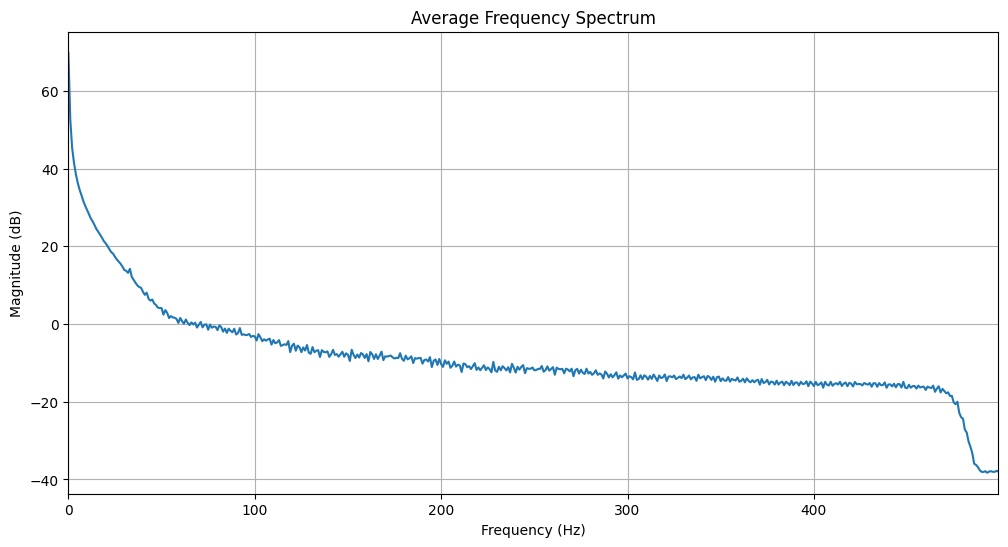

In [8]:
may_freqs, may_avg_spec, _ = calculate_average_frequencies(wav_df, 3, 1)
plot_average_spectrum(may_freqs, may_avg_spec)

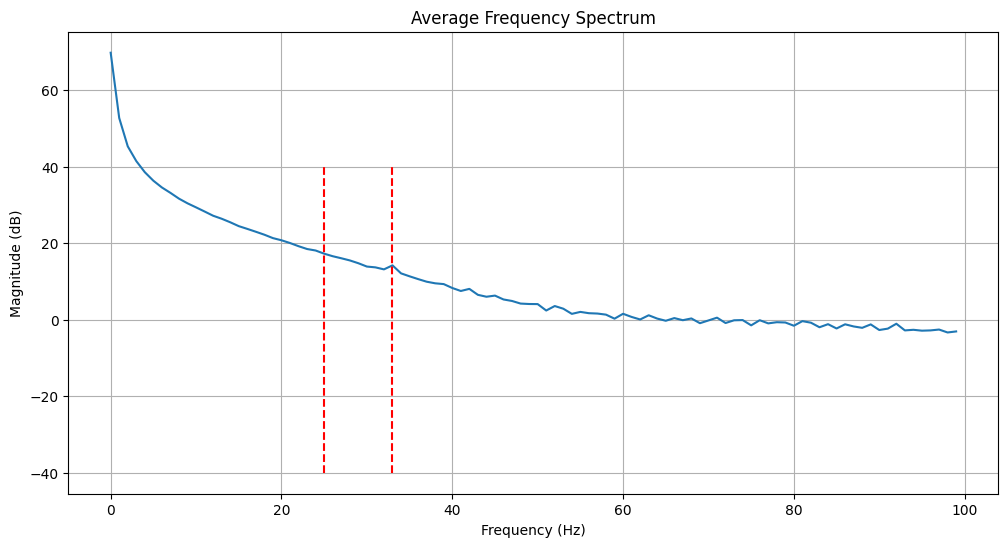

In [22]:
"""Plot the average frequency spectrum"""
plt.figure(figsize=(12, 6))
# plt.plot(freqs, 20 * np.log10(avg_spec + 1e-10))  # Convert to dB
plt.plot(freqs[: 100], 20 * np.log10(avg_spec[:100] + 1e-10))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Average Frequency Spectrum')
plt.grid(True)
# plt.xlim(0, freqs[-1])

plt.vlines(33, ymin=-40, ymax=40, colors='r', linestyles='dashed')
plt.vlines(25, ymin=-40, ymax=40, colors='r', linestyles='dashed')

# plt.vlines(40, ymin=-40, ymax=40, colors='r', linestyles='dashed')
# plt.text(30, -90, '30 Hz', color='r')

plt.show()

Found 720 WAV files


100%|██████████| 720/720 [01:20<00:00,  8.93it/s]


Interpolated file 1: 420007 -> 500 bins
Interpolated file 2: 420008 -> 500 bins
Interpolated file 3: 419997 -> 500 bins
Interpolated file 4: 419996 -> 500 bins
Interpolated file 5: 419997 -> 500 bins
Interpolated file 6: 419990 -> 500 bins
Interpolated file 7: 420002 -> 500 bins
Interpolated file 8: 420012 -> 500 bins
Interpolated file 9: 419991 -> 500 bins
Interpolated file 10: 420002 -> 500 bins
Interpolated file 11: 420009 -> 500 bins
Interpolated file 12: 420002 -> 500 bins
Interpolated file 13: 420013 -> 500 bins
Interpolated file 14: 419991 -> 500 bins
Interpolated file 15: 420007 -> 500 bins
Interpolated file 16: 419991 -> 500 bins
Interpolated file 17: 420010 -> 500 bins
Interpolated file 18: 420006 -> 500 bins
Interpolated file 19: 419984 -> 500 bins
Interpolated file 20: 419985 -> 500 bins
Interpolated file 21: 419985 -> 500 bins
Interpolated file 22: 419988 -> 500 bins
Interpolated file 23: 419986 -> 500 bins
Interpolated file 24: 419999 -> 500 bins
Interpolated file 25: 420

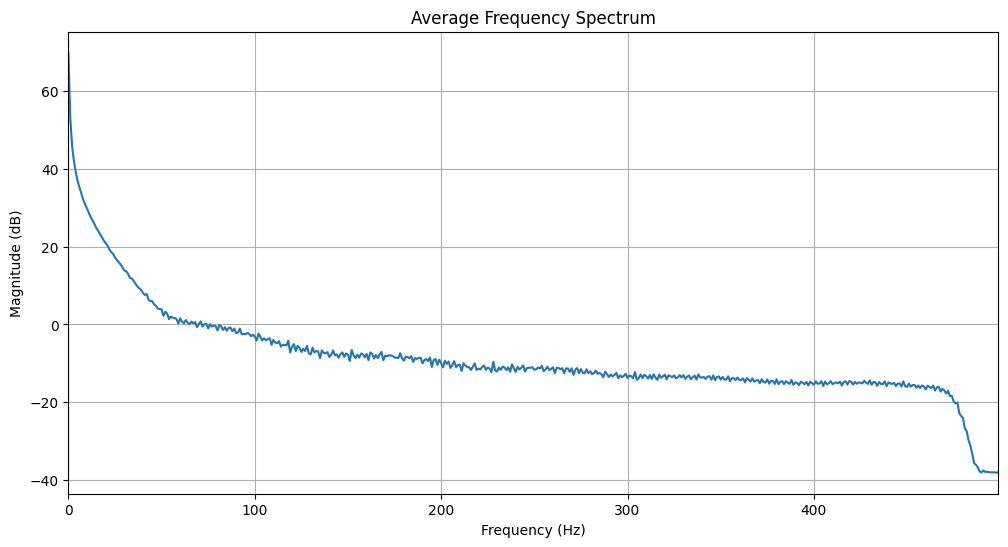

In [9]:
nov_freqs, nov_avg_spec, _ = calculate_average_frequencies(wav_df, 11, 1)
plot_average_spectrum(nov_freqs, nov_avg_spec)

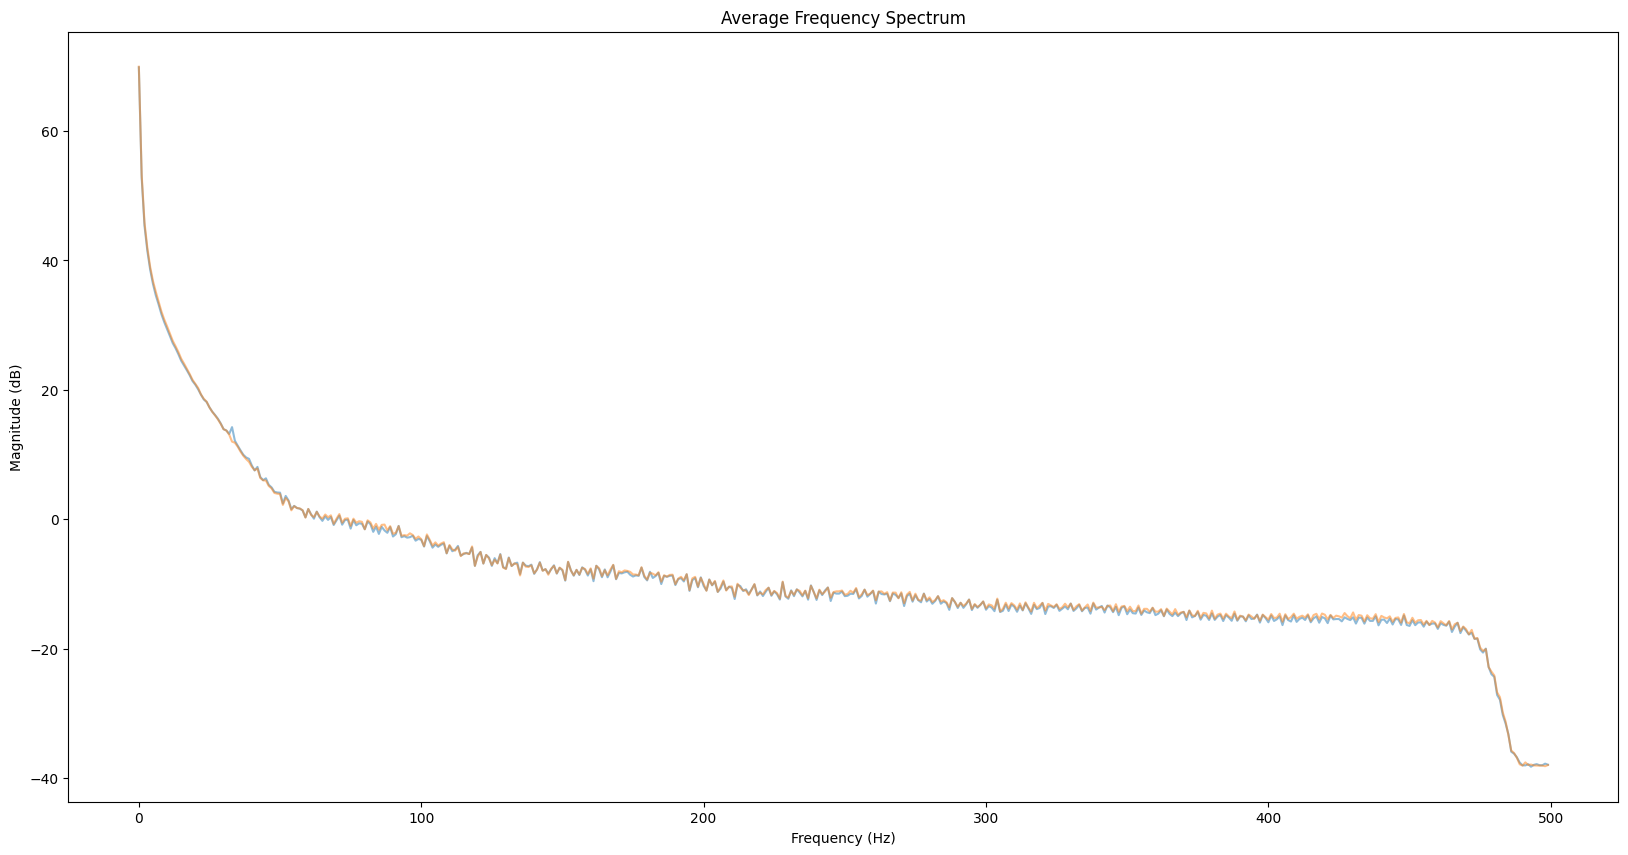

: 

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(may_freqs, 20 * np.log10(may_avg_spec + 1e-10), alpha=0.5)  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Average Frequency Spectrum')

plt.plot(nov_freqs, 20 * np.log10(nov_avg_spec + 1e-10), alpha=0.5)  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Average Frequency Spectrum')
plt.show()